## Title: Spam Email Classification Using SVMs -> Analyzing Parameter C
### Dataset Information:
    Source: https://archive.ics.uci.edu/ml/datasets/Spambase 
    Feature Type: Multivariate 
    Feature Data Type: Real Continous Numbers 
    Number of Observations: 4601 emails 
    Number of Features: 57 (continous features) + 1 (label) = 58 Total 
    Class Distribution: Spam      (1813 emails for 39.4%) 
                        Non-Spam  (2788 emails for 60.6%) 
    Missing Values: YES (Given by source), NO (By data exploration) 
    Rough Expected Estimate on Misclassification Error (Given by source): ~7% 
### Dataset Features:
    48 features of type word_freq_WORD in range [0,100], where values are continous real numbers. 
    6 features of type char_freq_CHAR in range [0,100], where values are continous real numbers. 
    1 feature of type capital_run_length_longest in range [1,2,....], where value is continous real integer.  
    1 feature of type capital_run_length_average in range[1,2,....], where value is continous real number. 
    1 feature of type capital_run_length_total in range [1,2,....], where value is continous real integer.  
    1 label in range [0,1], where value is 1 (spam) or 0 (non-spam).  
### Goal:
    Perform at least as well as given misclassification error mentioned by source (~7%) (Achieved)

In [10]:
# import standard libraries
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import pre-processing tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# import model
from sklearn.svm import SVC

### Data Extraction and Setup:
    1. Download the data set, open as a file object
    2. grab the column names
    3. slice the column names ->get rid after colon --> get rid colon
    4. grab the dataset and create dataframe
    5. get the basic descriptive statistics


In [2]:
# Download and grab the column names using file methods
f = open("spambase.names")
cols = []
for line in f:
    cols.append(line)
f.close()

cols = cols[33:]
cols.append('1 spam 2 non-spam')

for col in range(0, len(cols)):
    split = cols[col].split(":")[0]
    cols[col] = split

df = pd.read_csv("spambase.data", names = cols)
# 4601 observations, 58 columns
assert df.shape == (4601, 58) 

### Obtain the Basic Descriptive Statistics
    1. Get descriptive statistics
    2. Get the correlation matrix (representing possible linear correlation between each feature and respective label)

<AxesSubplot:>

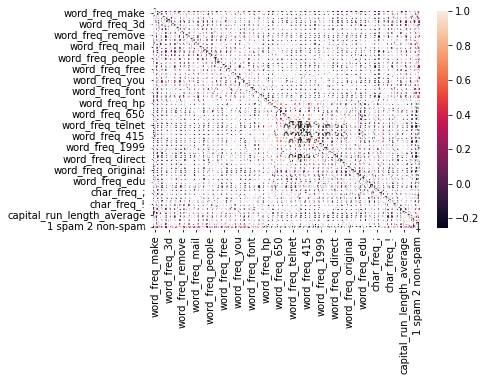

In [3]:
df_desc = df.describe()
df_corr = df.corr().round(2)

df_desc.head()

sns.heatmap(data=df_corr, annot=True)

### Data Cleaning (Common Cases)
    1. check for missing data / decide how to deal with it
    2. lowercases
    3. removing special charactesr
    4. remove stopwords
    5. remove hyperlinks
    6. remove numbers if needed
    7. remove whitespaces 

In [4]:
# check the data for missing values --> NO MISSING DATA
missing_data = df.isna().sum().sum()
total_entries = df.shape[0] * df.shape[1]
percentage_missing_entry = missing_data / total_entries
print("Amount of missing entries: ", missing_data)
print("Amound of total entries (Observations * Features): ", total_entries)
print("Percentage of missing entries: ", percentage_missing_entry)

Amount of missing entries:  0
Amound of total entries (Observations * Features):  266858
Percentage of missing entries:  0.0


### Data Pre-Processing
    1. Combine or remove any unnecessary rows (If needed)
    2. Split the data 70:30 (Given by HW assignment)
    3. Choose normalization or standardization with justification -> normalization
    4. dimensionality reduction (If needed)

In [5]:
# Split into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[:,:57], df.iloc[:,57], test_size = 0.3, random_state=(0))

# reshape the X sets
X_train = X_train.values.reshape((X_train.shape[0],57))
X_test = X_test.values.reshape((X_test.shape[0], 57))

# reshape the Y sets
Y_train = Y_train.values.reshape((Y_train.shape[0],1))
Y_test = Y_test.values.reshape((Y_test.shape[0], 1))

# confirm the shapes of sets
print("X_train: ", X_train.shape)
print("X_test:  ", X_test.shape)
print("Y_train: ", Y_train.shape)
print("Y_test:  ", Y_test.shape)

X_train:  (3220, 57)
X_test:   (1381, 57)
Y_train:  (3220, 1)
Y_test:   (1381, 1)


In [6]:
# This is the code if choosing the standardize the data with StandardScaler()
# It will move the data towards a normal distribution with mean = 0, scales to unit variance
# This assumes the data approximates a normal distribution
# For outliers, StandardScaler does not gurantee balanced feature scales. leads to shrinkage in the range of feature values. 
# Y is a label classifier and therefore does not need to be scaled. 
# normality assumption may not work for our dataset, and since we are using SVMs in high dimensional space, where distance matters, we will use normalization. 

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [7]:
# this is the code if choosing normalization with MinMaxScaler()
# Does not assume normal distribution. 
# Works well if we do not want to assume weights/bias, and working with algorithms that depend on distance. 
# minmaxscaler scales all data into ranges of [0,1] for each feature. Scales to [-1,1] if data has negative values.
# Compresses inliers to range [0,0.005]
# if using robust scaler, we can remove outliers and then use standardscaler or minmaxscaler for preprocessing the dataset. 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modeling / Predicting / Scoring: SVMs
### Parameters:
    1. similarity function (kernels is linear, quadratic, rbf)
    2. C: controls tradeoff between classification of training points accurately and smooth decision boundars. 
        If the value of C is large:
            Model may choose more data points as support vector
            Leads to higher variance
            Lower bias
            May lead to overfitting
        If value of C is small:
            Model may choose fewer data points as support vector. 
            Lower variance
            Higher Bias
            May lead to underfitting. 
    3. Gamma is RBF: defines how far the influence of a single training examples reaches. 
        If gamma is high, margin will depend on points closest to it. Nearer points carry more weight than points farther away. Margin more wiggly.
        If gamme is low, points farther away have more weight, and margin becomes more straight.
        
### sklearn.SVM.SVC model:
    Attributes:
        class_weight: multipliers of parameter C for each class. 
        classes: class labels
        dual_coeff: dual coeffs of support vector machinein the decision function multiplied by their targets
        fit_status_ 0 if fitted correctly, 1 otherwise (warning)
        intercept_: constants in decision function
        n_features_in_: num of features seen during fit
        feature_names_in: names of features seen during fit. Defined only when X has features names that are all strings
        n_iter_: number of iterations by the optizmation routine to fir the model
        support_: indeces of support vectors
        support_vectors
        n_support_: number of support vectors for each class
        probA_: paramters learned in Platt scaling when prob=True
        shape_fit_: array dimensions of training vector X
    Methods:
        decision_function(X): eval the decision function for the exmaples in X
        fit(xtrain, ytrain): Fit the SVM model according to the given training data
        get_params([deep]): get parameters for this estimator
        predict(Xtest): perform classification on samples in X
        predict_log_proba(X): compute log proababilities of possible outcomes for samples in X
        predict_proba(X): compute probabilities of possible outcomes for sampels in X
        score(test samples, true labels): return mean accuranc on given test data and labels
        set_params(**params): set parameters of this estimator.

In [8]:
# list of C parameters
c_vals = [10**(-2), 10**(-1), 10**(0), 10**(1), 10**(2), 10**(3), 10**(4)]
# Linear accruacy, tuples(train accuracy, test accuracy) for each C
linear_accur = []
# quadratic acc, 2 lists
quad_accur = []
# rbf accur, 2 lists
rbf_accur = []

# predict
for c in c_vals:
    
    # create model for each kernel
    # fit/train each model on X_train, Y_train
    # predict on training, score
    # predict on test, score
    model_linear = SVC(C=c, kernel = "linear")
    model_linear.fit(X_train, Y_train) 
    score_linear_train = model_linear.score(X_train, Y_train).round(4)
    score_linear_test = model_linear.score(X_test, Y_test).round(4)
       
    model_quad = SVC(C=c, kernel = "poly", degree = 2)
    model_quad.fit(X_train, Y_train)
   
    score_quad_train = model_quad.score(X_train, Y_train).round(4)
    score_quad_test = model_quad.score(X_test, Y_test).round(4)
       
    model_rbf = SVC(C=c, kernel = "rbf", gamma = "scale")
    model_rbf.fit(X_train, Y_train)
    score_rbf_train = model_rbf.score(X_train, Y_train).round(4)
    score_rbf_test = model_rbf.score(X_test, Y_test).round(4)
       
    linear_accur.append((score_linear_train, score_linear_test))
    quad_accur.append((score_quad_train, score_quad_test))
    rbf_accur.append((score_rbf_train, score_rbf_test))

C:\Users\AMDPower\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMDPower\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMDPower\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\AMDPower\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_

### Scores of each Kernel with each C value:

<AxesSubplot:>

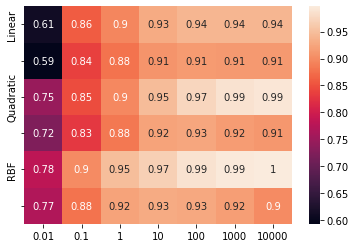

In [9]:
lin_train = [x[0] for x in linear_accur]
lin_test = [x[1] for x in linear_accur]
quad_train =[x[0] for x in quad_accur]
quad_test =[x[1] for x in quad_accur]
rbf_train =[x[0] for x in rbf_accur]
rbf_test =[x[1] for x in rbf_accur]

res_minmaxscalar = [lin_train, lin_test, quad_train, quad_test, rbf_train, rbf_test]
df_res = pd.DataFrame(res_minmaxscalar)
    
c_vals = [str(c) for c in c_vals]

sns.heatmap(df_res, annot = True, xticklabels = c_vals, yticklabels=['Linear','','Quadratic','','RBF',''])